In [2]:
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
SAVE_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase/results'
import pandas as pd
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [347]:
def load_results_div(DATASET):
    with open(f'{ROOT_DIR}/results/{DATASET}/{DATASET}_divergence_metrics_full.pkl', 'rb') as f :
        results = pickle.load(f)
    return results

def load_cost_div(DATASET):
    results = load_results_div(DATASET)
    data = []
    for cost in results:
        for run_index, sublist in enumerate(results[cost][f'{metric}']):
            values_series = pd.Series(sublist).iloc[:50]
            ema_result = values_series.ewm(span=10, adjust=False).mean()
            for epoch, value in enumerate(ema_result):
                data.append({'Cost': cost, 'epoch':epoch, 'Run Index': run_index, 'Value': value})
    df = pd.DataFrame(data)
    div_results = df.groupby(['epoch', 'Cost'])[['Value']].median().reset_index()
    dataset_costs =  pd.read_csv(f'{ROOT_DIR}/results/wasserstein/Wasserstein_{DATASET}.csv').dropna()
    dataset_costs = dataset_costs.merge(div_results, left_on = 'Ours', right_on = 'Cost')
    dataset_costs['dataset'] = DATASET 
    return dataset_costs

def load_all_costs_div(DATASETS):
    all_datasets_costs = pd.DataFrame()
    for DATASET in DATASETS:
        dataset_costs =  load_cost_div(DATASET)
        all_datasets_costs = pd.concat([all_datasets_costs, dataset_costs])
    return all_datasets_costs

def grapher_grad(DATASET, metric, save):
    y_label = {'weight_div':'Weight divergence', 'weight_div_orient': 'Weight divergence (orient)', 'grad_div':'Gradient diversity'}
    results = load_results_div(DATASET)
    for cost in results:
        data = []
        for run_index, sublist in enumerate(results[cost][f'{metric}']):
            values_series = pd.Series(sublist).iloc[:50]
            ema_result = values_series.ewm(span=5, adjust=False).mean()
            for epoch, value in enumerate(ema_result):
                data.append({'Cost': cost, 'epoch':epoch, 'Run Index': run_index, 'Value': value})
        df = pd.DataFrame(data)
        sns.lineplot(data=df, x='epoch', y='Value', estimator='median', label = cost, errorbar=None)
    plt.xlabel('Epoch', fontsize = 14)
    plt.ylabel(f'{y_label[metric]}', fontsize = 14)
    plt.legend(title = 'Score', title_fontsize=14, fontsize = 14)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params(axis='both', which='both', length=0)
    if save == True:
        plt.savefig(f'{SAVE_DIR}/{DATASET}/{DATASET}_{metric}.pdf', bbox_inches='tight')
    plt.show()

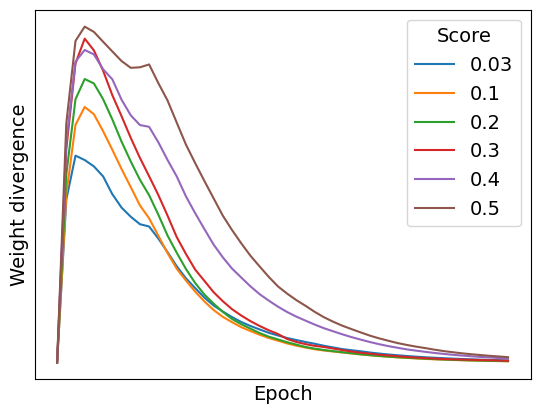

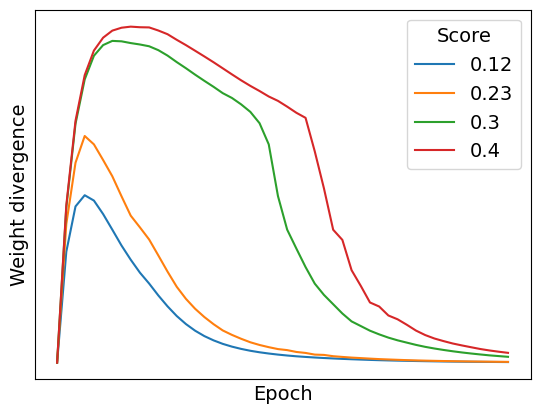

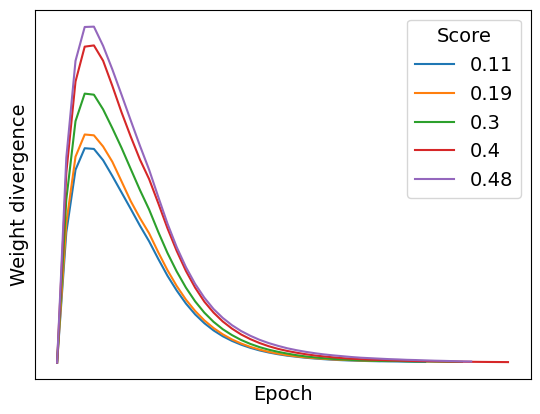

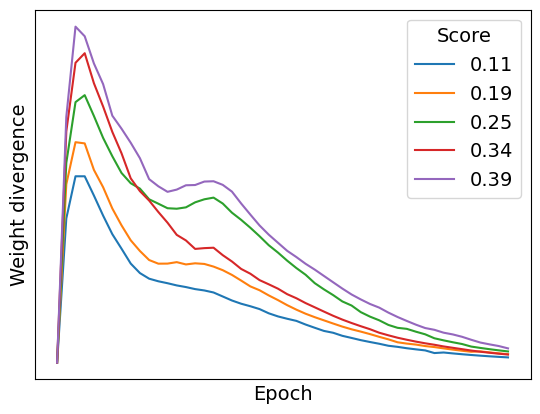

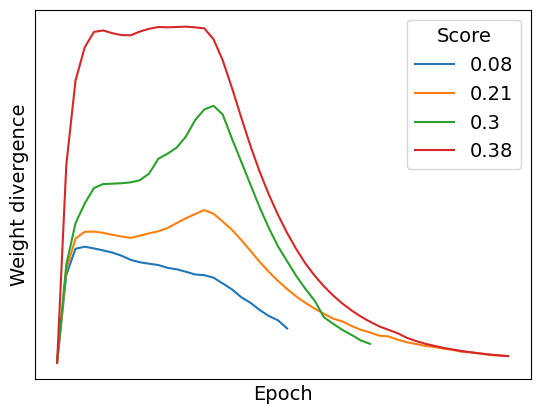

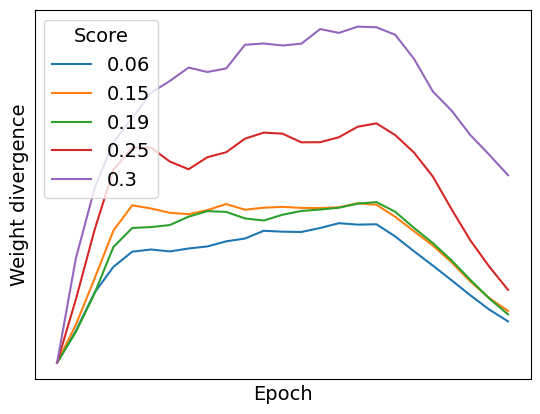

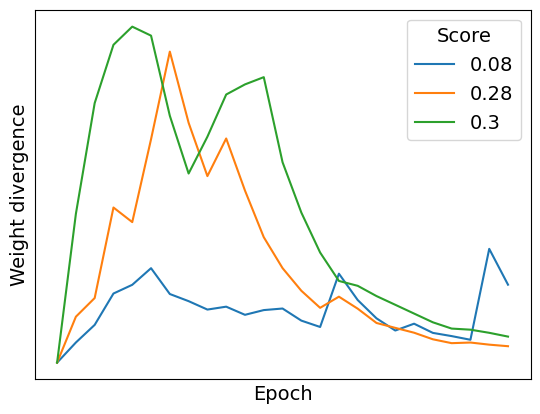

In [311]:
DATASETS = ['Synthetic', 'Credit', 'Weather',
            'EMNIST', 'CIFAR', 'ISIC', 'IXITiny']
for DATASET in DATASETS:
    metric = 'weight_div'
    save = True
    grapher_grad(DATASET, metric, save)

In [387]:
data = load_cost_div(DATASET)

In [389]:
data.groupby('Cost').max()
#corr_ours, corr_wass = stats.pearsonr(data['Value'], data['Ours']), stats.pearsonr(data['Value'], data['Wasserstein'])

,Ours,Wasserstein,epoch,Value,dataset
Cost,,,,,
0.08,0.08,3.950458e+05,24,0.093377,IXITiny
0.28,0.28,1.043485e+08,24,0.224582,IXITiny
0.30,0.30,6.756034e+08,24,0.283301,IXITiny


In [402]:
DATASETS = ['Synthetic', 'Credit', 'Weather',
            'EMNIST', 'CIFAR', 'ISIC', 'IXITiny']
corr_results = {}
for DATASET in DATASETS:
    data = load_cost_div(DATASET)
    data = data.groupby('Cost').max()
    corr_ours, corr_wass = stats.pearsonr(data['Value'], data['Ours']), stats.pearsonr(data['Value'], data['Wasserstein'])
    corr_results[DATASET]= [corr_ours[0], corr_ours[1], corr_wass[0], corr_wass[1]]
data = load_all_costs_div(DATASETS)
corr_ours, corr_wass = stats.pearsonr(data['Value'], data['Ours']), stats.pearsonr(data['Value'], data['Wasserstein'])
corr_results['all']= [corr_ours[0], corr_ours[1], corr_wass[0], corr_wass[1]]

In [405]:
corr_results_df = pd.DataFrame.from_dict(corr_results, orient = 'index', columns = ['Ours', 'Pvalue', 'Wasserstein', 'Pvalue'])
corr_results_df.to_csv(f'{ROOT_DIR}/results/div_metrics/weight_div_corr.csv')
corr_results_df

,Ours,Pvalue,Wasserstein,Pvalue
Synthetic,0.976227,8.409931e-04,0.962915,0.002037
Credit,0.936549,6.345091e-02,0.902592,0.097408
Weather,0.990221,1.159085e-03,0.688217,0.198920
EMNIST,0.987691,1.636267e-03,0.677256,0.209117
CIFAR,0.971278,2.872236e-02,0.848895,0.151105
ISIC,0.886744,4.496813e-02,0.884502,0.046294
IXITiny,0.974923,1.428714e-01,0.827012,0.380078
all,0.221534,3.077691e-16,0.017799,0.516776


In [406]:
stats.ttest_rel(corr_results_df['Ours'], corr_results_df['Wasserstein'])

Ttest_relResult(statistic=3.264267844735121, pvalue=0.01378293216167107)